LIBRARIES USED

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore


IMPORTING DATASETS

In [2]:
df1=pd.read_csv("datasets\\apps.csv")
df2=pd.read_csv("datasets\\user_reviews.csv")

PRE PROCESSING

In [3]:
#Handling Missing values
#Cleaning the data in columns

df1 = df1.dropna(subset=['Android Ver', 'Current Ver'])
df1['Current Ver'] = ["Unknown" if val != val else val for val in df1['Current Ver']]
df1['Current Ver'] = df1['Current Ver'].apply(lambda x: str(x).split('.')[0] if x != 'not mentioned' else 'not mentioned')
df1['Current Ver'] = df1['Current Ver'].apply(lambda x: x if x.isdigit() else 'Unknown')

df1['Android Ver'] = ["Unknown" if val != val else val for val in df1['Android Ver']]
df1['Android Ver'] = df1['Android Ver'].apply(lambda x: str(x).split('.')[0] if x != 'not mentioned' else 'not mentioned')

df1['Installs'] = [int(str(val).replace(',', '').replace('+', '')) for val in df1['Installs']]

df1['Price'] = [float(str(val).replace('$', '')) if val != 'Free' else 0.0 for val in df1['Price']]

df1['Type'] = [1 if val == "Paid" else 0 for val in df1['Type']]

def convert_date(date_str):
    months = {
        'January': '01', 'February': '02', 'March': '03', 'April': '04',
        'May': '05', 'June': '06', 'July': '07', 'August': '08',
        'September': '09', 'October': '10', 'November': '11', 'December': '12'
    }
    date_parts = date_str.split()
    month = months[date_parts[0]]
    day = date_parts[1].replace(',', '').zfill(2)
    year = date_parts[2]
    return f"{year}-{month}-{day}"

df1['Last Updated'] = df1['Last Updated'].apply(convert_date)

#Scaling colmns
columns_to_scale = ['Reviews', 'Size', 'Installs']
scaler = MinMaxScaler()
df1[columns_to_scale] = scaler.fit_transform(df1[columns_to_scale])

#Outlier Detection
columns_to_check = df1.select_dtypes(include=[np.number]).columns
for col in columns_to_check:
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df1 = df1[(df1[col] >= lower_bound) & (df1[col] <= upper_bound)]


In [4]:
#Removing unnecessary columns  
df1 = df1.loc[:, df1.columns != 'Unnamed: 0']

df1 = df1.drop(columns=['Genres'])
main_categories = {
    'EDUCATION': 'EDUCATION & LEARNING',
    'BOOKS_AND_REFERENCE': 'EDUCATION & LEARNING',
    'LIBRARIES_AND_DEMO': 'EDUCATION & LEARNING',
    
    'ENTERTAINMENT': 'ENTERTAINMENT & MEDIA',
    'VIDEO_PLAYERS': 'ENTERTAINMENT & MEDIA',
    'MUSIC': 'ENTERTAINMENT & MEDIA',
    'COMICS': 'ENTERTAINMENT & MEDIA',
    
    'GAME': 'GAMING',
    'CASINO': 'GAMING',
    
    'ART_AND_DESIGN': 'CREATIVITY & ART',
    'PHOTOGRAPHY': 'CREATIVITY & ART',
    'PERSONALIZATION': 'CREATIVITY & ART',
    
    'LIFESTYLE': 'LIFESTYLE & WELLNESS',
    'BEAUTY': 'LIFESTYLE & WELLNESS',
    'FASHION': 'LIFESTYLE & WELLNESS',
    'FOOD_AND_DRINK': 'LIFESTYLE & WELLNESS',
    'HEALTH_AND_FITNESS': 'LIFESTYLE & WELLNESS',
    'HOUSE_AND_HOME': 'LIFESTYLE & WELLNESS',
    'PARENTING': 'LIFESTYLE & WELLNESS',
    'SPORTS': 'LIFESTYLE & WELLNESS',
    
    'BUSINESS': 'CORPORATE & CONSUMER SERVICES',
    'FINANCE': 'CORPORATE & CONSUMER SERVICES',
    'SHOPPING': 'CORPORATE & CONSUMER SERVICES',

    'SOCIAL': 'SOCIAL CONNECTIONS',
    'COMMUNICATION': 'SOCIAL CONNECTIONS',
    'DATING': 'SOCIAL CONNECTIONS',
    
    'TOOLS': 'UTILITIES',
    'PRODUCTIVITY': 'UTILITIES',
    
    'TRAVEL_AND_LOCAL': 'TRAVEL & NAVIGATION',
    'MAPS_AND_NAVIGATION': 'TRAVEL & NAVIGATION',
    'AUTO_AND_VEHICLES': 'TRAVEL & NAVIGATION',
    
    'NEWS_AND_MAGAZINES': 'NEWS',
    'WEATHER': 'NEWS',
    'EVENTS': 'NEWS',
    'MEDICAL': 'HEALTH RELATED'
}
df1['Section'] = df1['Category'].map(main_categories)


In [5]:
df2 = df2.dropna()

numeric_df2 = df2.select_dtypes(include=['float64', 'int64'])
Q1 = numeric_df2.quantile(0.25)
Q3 = numeric_df2.quantile(0.75)
IQR = Q3 - Q1

outlier_condition = ((numeric_df2 < (Q1 - 1.5 * IQR)) | (numeric_df2 > (Q3 + 1.5 * IQR))).any(axis=1)
df2 = df2[~outlier_condition]

# Clean and preprocess text data
df2['Translated_Review'] = df2['Translated_Review'].str.lower()
df2['Translated_Review'] = df2['Translated_Review'].str.replace(r'[^a-zA-Z\s]', '', regex=True)
# Remove stopwords
stopwords = ['a', 'the', 'is', 'and', 'to', 'in', 'for', 'on', 'with', 'at']
df2['Translated_Review'] = df2['Translated_Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

# Perform stemming
def stem_text(text):
    words = text.split()
    stemmed_words = [word[:-1] if word.endswith('s') else word for word in words]
    return ' '.join(stemmed_words)
df2['Translated_Review'] = df2['Translated_Review'].apply(stem_text)

# Normalize sentiment polarity and subjectivity to the range of 1 to 10
scaler = MinMaxScaler(feature_range=(1, 10))
df2[['Sentiment_Polarity', 'Sentiment_Subjectivity']] = scaler.fit_transform(df2[['Sentiment_Polarity', 'Sentiment_Subjectivity']])

df2['Sentiment'] = df2['Sentiment'].astype('category')
df2['Translated_Review'] = df2['Translated_Review'].astype(str)
df2['App'] = df2['App'].astype(str)


DATA ANALYSIS

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4435 entries, 0 to 9655
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             4435 non-null   object 
 1   Category        4435 non-null   object 
 2   Rating          4435 non-null   float64
 3   Reviews         4435 non-null   float64
 4   Size            4435 non-null   float64
 5   Installs        4435 non-null   float64
 6   Type            4435 non-null   int64  
 7   Price           4435 non-null   float64
 8   Content Rating  4435 non-null   object 
 9   Last Updated    4435 non-null   object 
 10  Current Ver     4435 non-null   object 
 11  Android Ver     4435 non-null   object 
 12  Section         3498 non-null   object 
dtypes: float64(5), int64(1), object(7)
memory usage: 485.1+ KB


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36690 entries, 0 to 64230
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   App                     36690 non-null  object  
 1   Translated_Review       36690 non-null  object  
 2   Sentiment               36690 non-null  category
 3   Sentiment_Polarity      36690 non-null  float64 
 4   Sentiment_Subjectivity  36690 non-null  float64 
dtypes: category(1), float64(2), object(2)
memory usage: 1.4+ MB


DATA ANALYSIS

1.What are the most popular categories of apps based on the number of installs?

C:\Users\DELL\AppData\Local\Temp\ipykernel_12132\3899342766.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_installs.values[:10], y=category_installs.index[:10], palette='viridis')


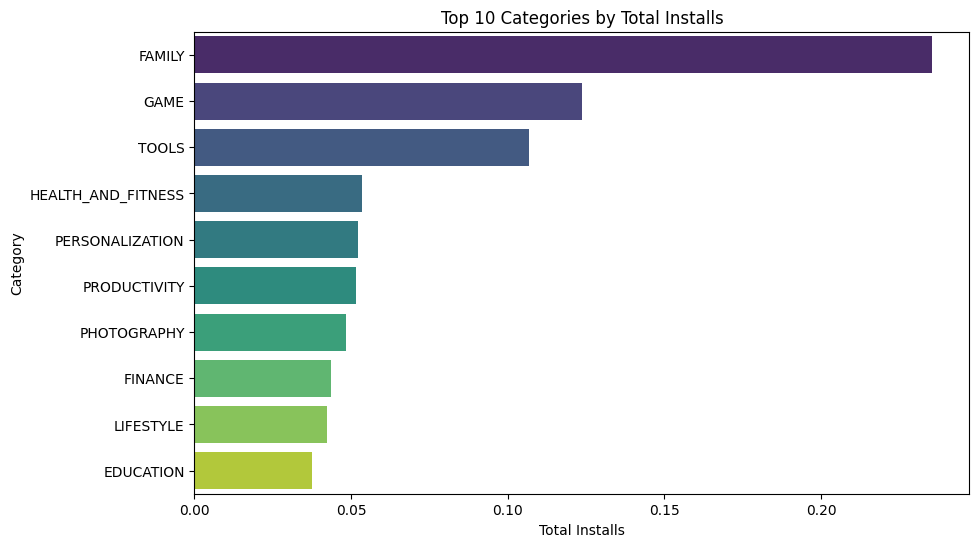

In [8]:
category_installs = df1.groupby('Category')['Installs'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=category_installs.values[:10], y=category_installs.index[:10], palette='viridis')
plt.title('Top 10 Categories by Total Installs')
plt.xlabel('Total Installs')
plt.ylabel('Category')
plt.show()


2.Is there a relationship between app ratings and the size of the app?

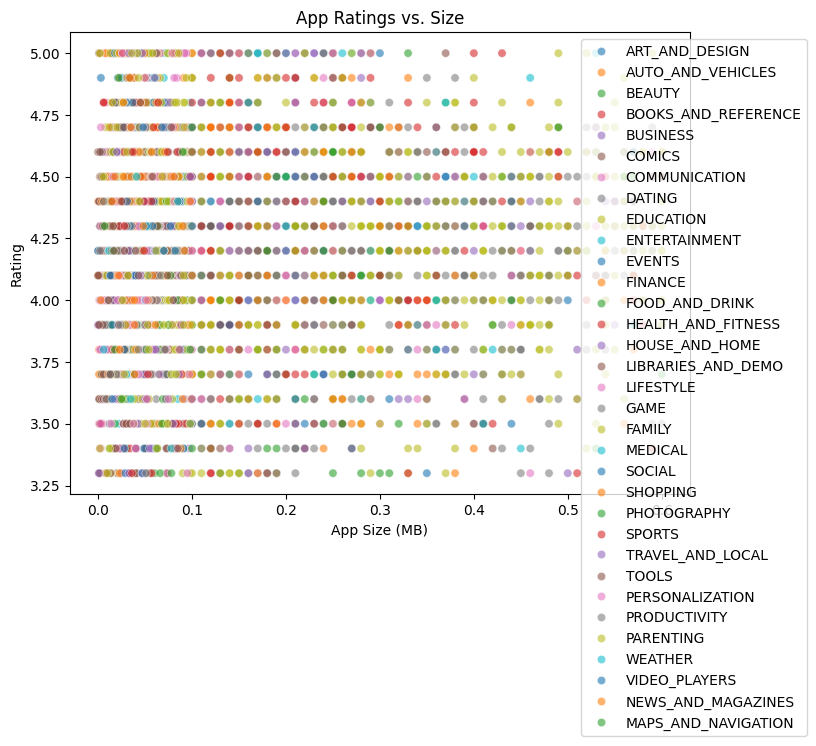

In [9]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df1, x='Size', y='Rating', alpha=0.6, hue='Category', palette='tab10')
plt.title('App Ratings vs. Size')
plt.xlabel('App Size (MB)')
plt.ylabel('Rating')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()


In [11]:
# Merging datasets
merged_df = pd.merge(df1, df2, on='App', how='inner')

3.How does the sentiment polarity vary by app category?

C:\Users\DELL\AppData\Local\Temp\ipykernel_12132\410917759.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_sentiment.values[:10], y=category_sentiment.index[:10], palette='coolwarm')


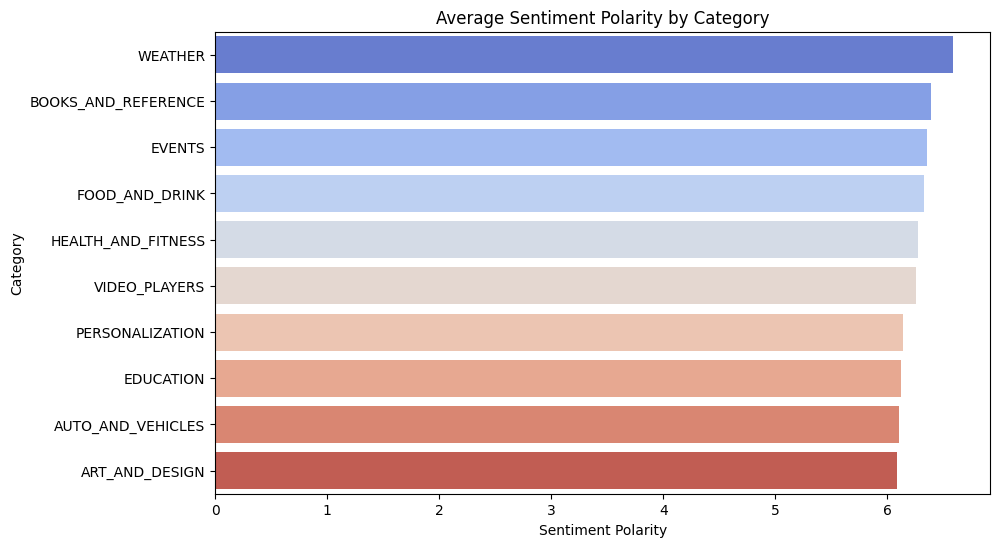

In [12]:
category_sentiment = merged_df.groupby('Category')['Sentiment_Polarity'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=category_sentiment.values[:10], y=category_sentiment.index[:10], palette='coolwarm')
plt.title('Average Sentiment Polarity by Category')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Category')
plt.show()


4.How do pricing and app type (free vs. paid) affect app ratings?

C:\Users\DELL\AppData\Local\Temp\ipykernel_12132\2468177574.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df1, x='Type', y='Rating', palette='Set2')


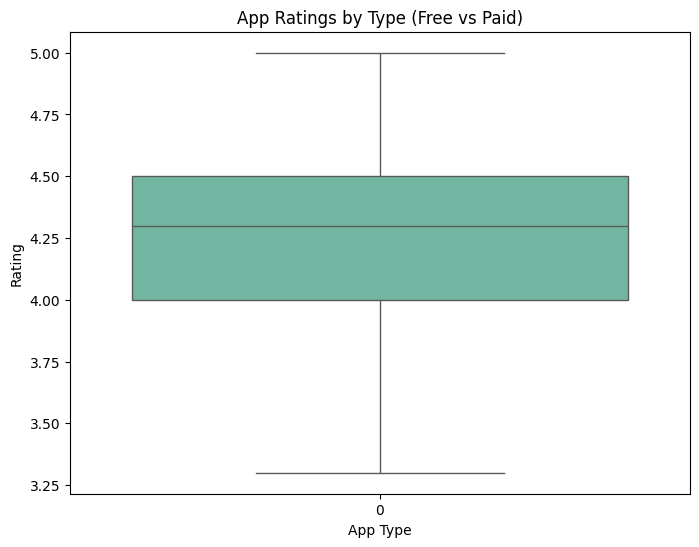

In [13]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df1, x='Type', y='Rating', palette='Set2')
plt.title('App Ratings by Type (Free vs Paid)')
plt.xlabel('App Type')
plt.ylabel('Rating')
plt.show()


5.Which apps receive the most positive or negative reviews?

C:\Users\DELL\AppData\Local\Temp\ipykernel_12132\2967038637.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_positive_apps.values, y=top_positive_apps.index, palette='crest')


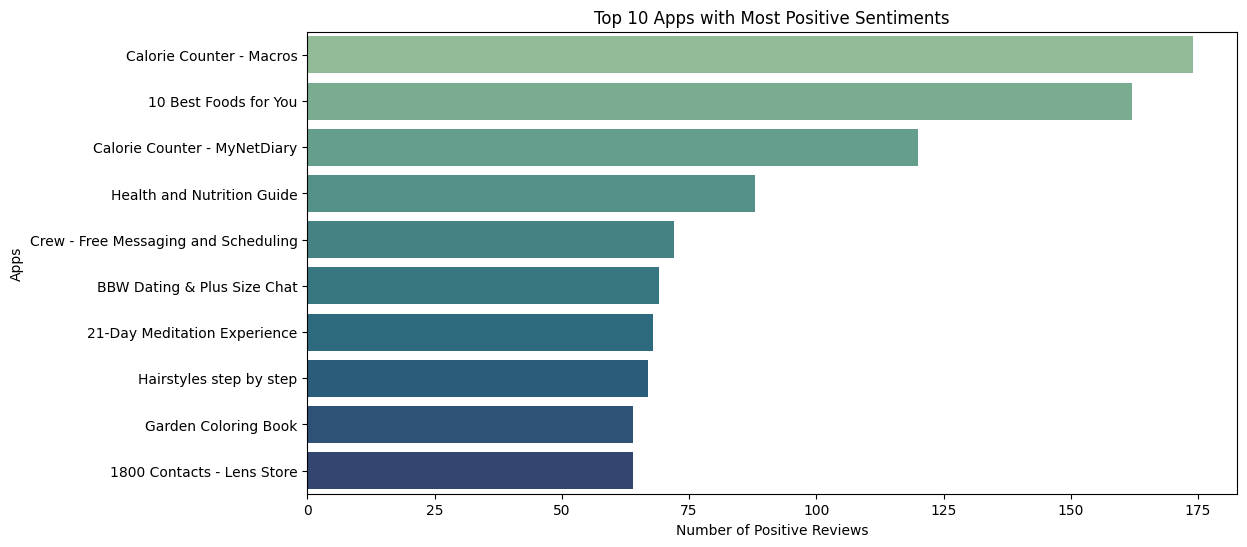

C:\Users\DELL\AppData\Local\Temp\ipykernel_12132\2967038637.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_negative_apps.values, y=top_negative_apps.index, palette='magma')


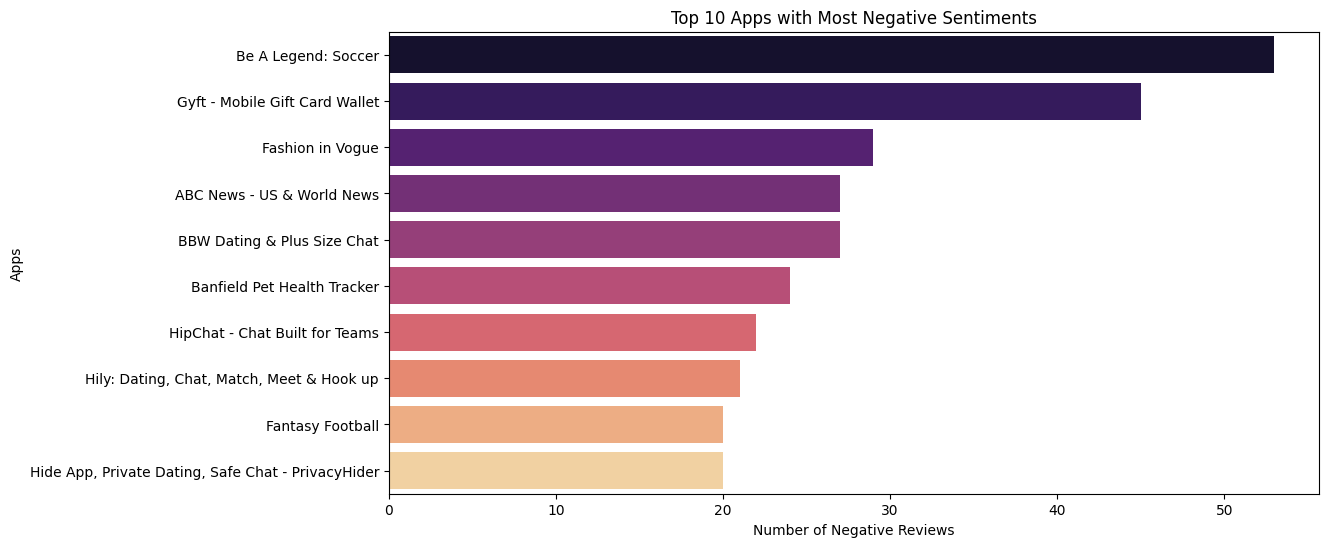

In [14]:
top_positive_apps = merged_df[merged_df['Sentiment'] == 'Positive']['App'].value_counts().head(10)
top_negative_apps = merged_df[merged_df['Sentiment'] == 'Negative']['App'].value_counts().head(10)

# Plot Positive Sentiments
plt.figure(figsize=(12, 6))
sns.barplot(x=top_positive_apps.values, y=top_positive_apps.index, palette='crest')
plt.title('Top 10 Apps with Most Positive Sentiments')
plt.xlabel('Number of Positive Reviews')
plt.ylabel('Apps')
plt.show()

# Plot Negative Sentiments
plt.figure(figsize=(12, 6))
sns.barplot(x=top_negative_apps.values, y=top_negative_apps.index, palette='magma')
plt.title('Top 10 Apps with Most Negative Sentiments')
plt.xlabel('Number of Negative Reviews')
plt.ylabel('Apps')
plt.show()


6.Are apps with higher installs or reviews more likely to have higher sentiment subjectivity?

C:\Users\DELL\AppData\Local\Temp\ipykernel_12132\1520165818.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x='Category', y='Sentiment_Subjectivity', palette='cool')


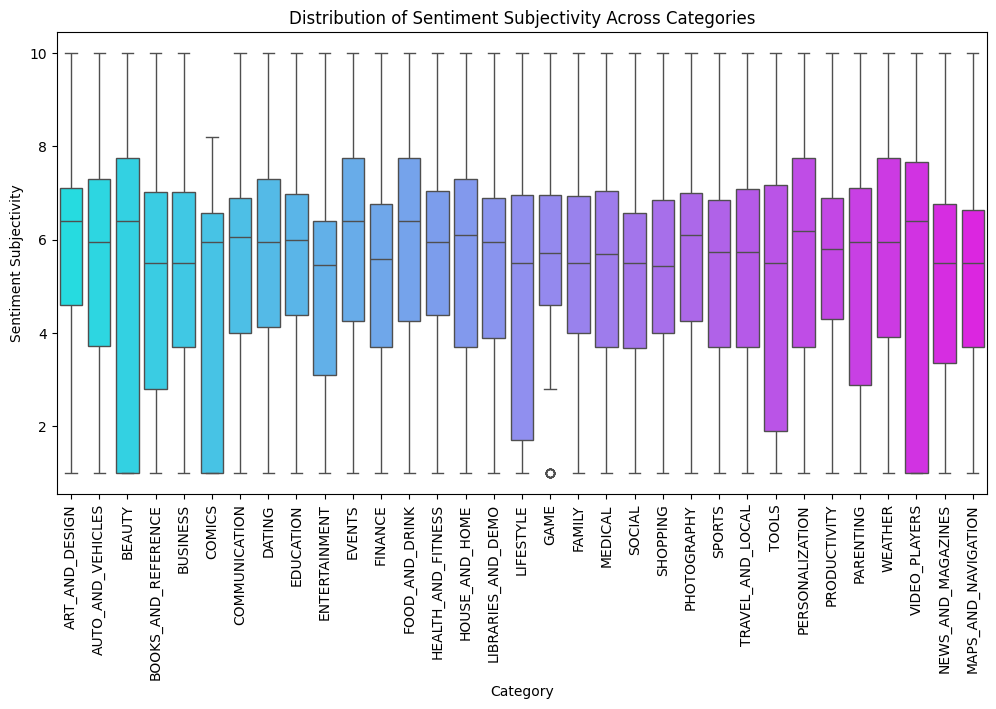

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df, x='Category', y='Sentiment_Subjectivity', palette='cool')
plt.xticks(rotation=90)
plt.title('Distribution of Sentiment Subjectivity Across Categories')
plt.xlabel('Category')
plt.ylabel('Sentiment Subjectivity')
plt.show()


7.Heatmap of Ratings and Sentiments Across Categories

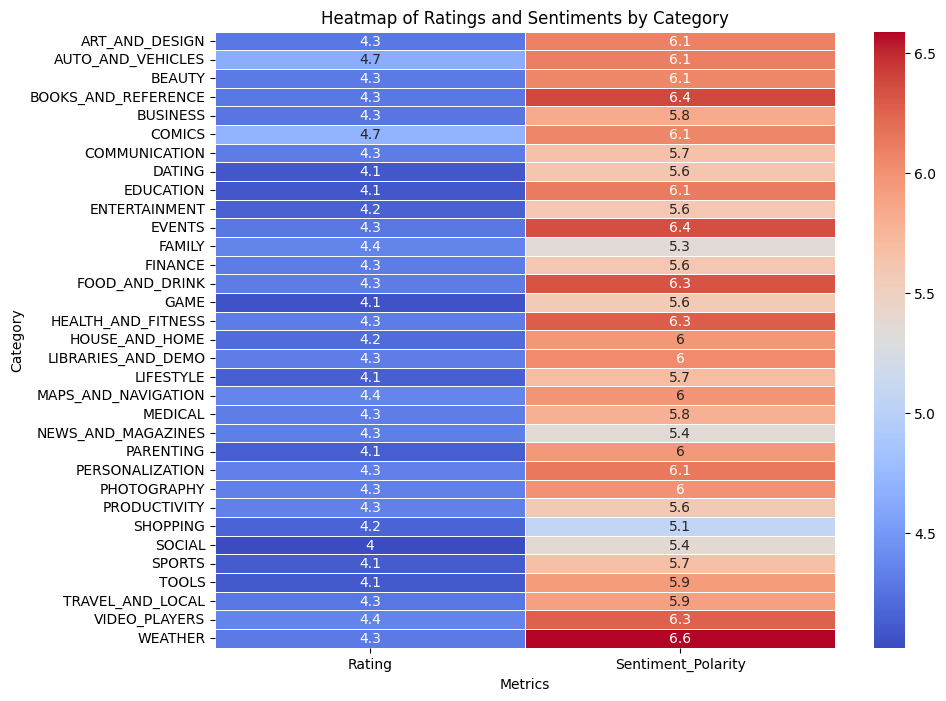

In [16]:
category_sentiment_rating = merged_df.pivot_table(index='Category', values=['Rating', 'Sentiment_Polarity'], aggfunc='mean')

plt.figure(figsize=(10, 8))
sns.heatmap(category_sentiment_rating, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Ratings and Sentiments by Category')
plt.xlabel('Metrics')
plt.ylabel('Category')
plt.show()


8.Pair Plot for Numerical Features

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigne

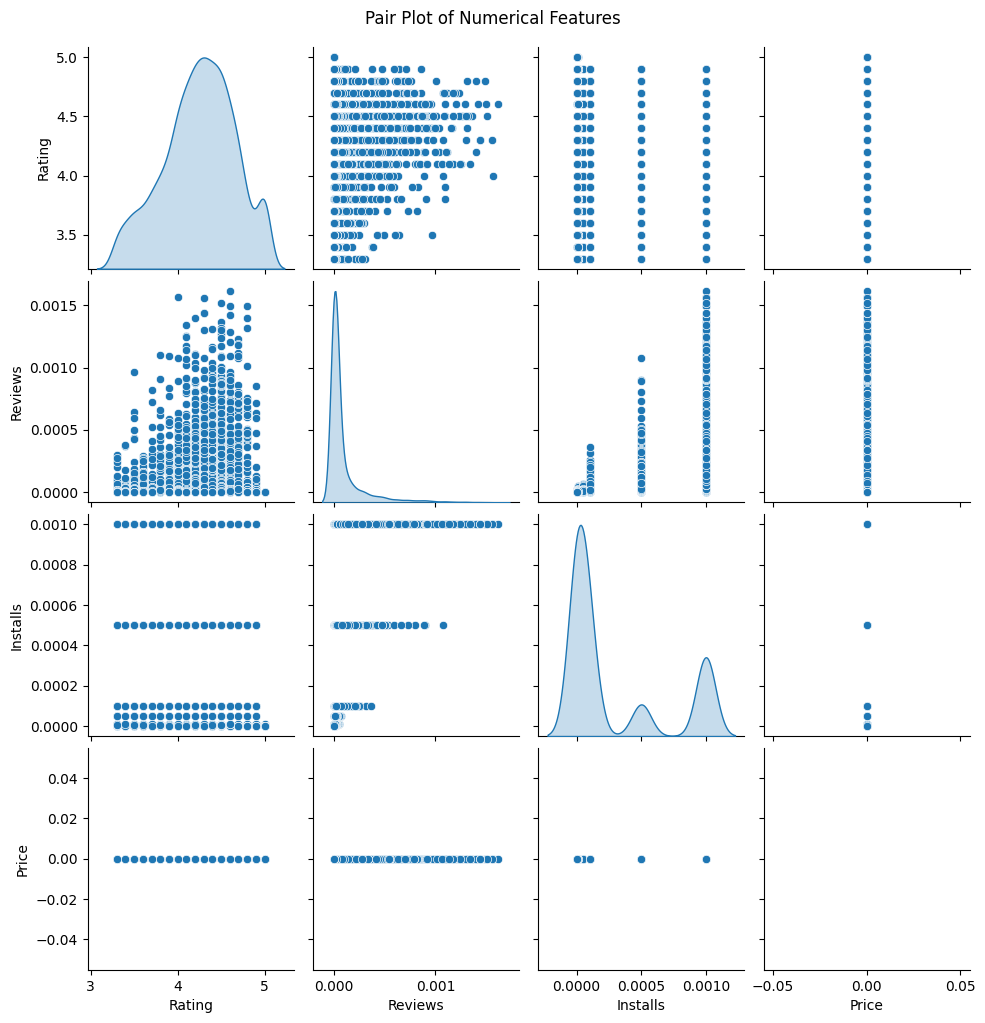

In [18]:
sns.pairplot(df1[['Rating', 'Reviews', 'Installs', 'Price']], diag_kind='kde', palette='husl')
plt.suptitle('Pair Plot of Numerical Features', y=1.02)
plt.show()


9.Side-by-Side Bar Chart: average rating and average sentiment
-Average ratings reflect the quantitative feedback (direct user scoring), while sentiment polarity provides a qualitative measure derived from user comments/reviews.
Together, they give a holistic view of user satisfaction and sentiment towards apps in each category.

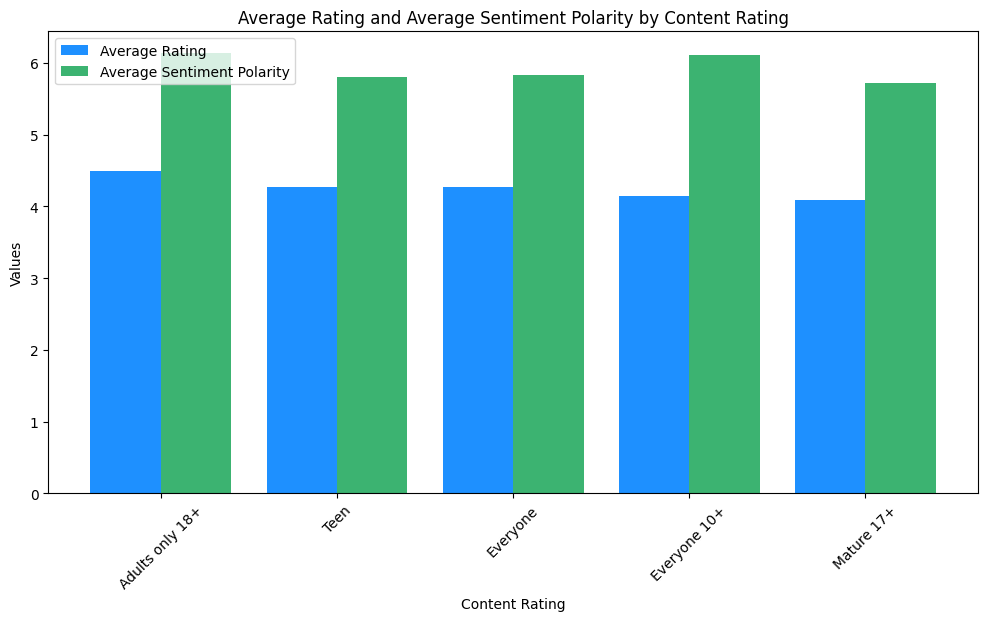

In [21]:
# Compute average rating and average sentiment polarity for each content rating
content_stats = merged_df.groupby('Content Rating').agg({'Rating': 'mean', 'Sentiment_Polarity': 'mean'}).sort_values(by='Rating', ascending=False)

# Plotting side-by-side bar chart for better comparability
plt.figure(figsize=(12, 6))
bar_width = 0.4
indices = range(len(content_stats))

# Bar plots
plt.bar(indices, content_stats['Rating'], bar_width, label='Average Rating', color='dodgerblue')
plt.bar([i + bar_width for i in indices], content_stats['Sentiment_Polarity'], bar_width, label='Average Sentiment Polarity', color='mediumseagreen')

# Customizing ticks and labels
plt.xticks([i + bar_width / 2 for i in indices], content_stats.index, rotation=45)
plt.title('Average Rating and Average Sentiment Polarity by Content Rating')
plt.xlabel('Content Rating')
plt.ylabel('Values')
plt.legend()
plt.show()


10.Line Chart for Average Sentiment Polarity Over Categories

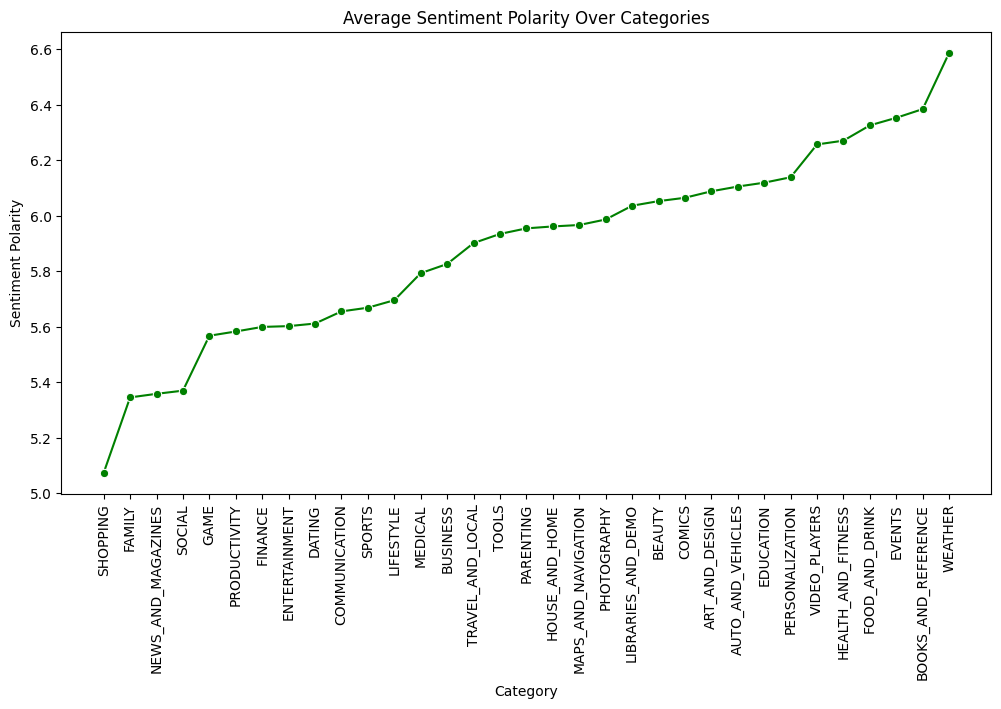

In [22]:
category_polarity = merged_df.groupby('Category')['Sentiment_Polarity'].mean().reset_index().sort_values(by='Sentiment_Polarity')

plt.figure(figsize=(12, 6))
sns.lineplot(data=category_polarity, x='Category', y='Sentiment_Polarity', marker='o', color='green')
plt.xticks(rotation=90)
plt.title('Average Sentiment Polarity Over Categories')
plt.xlabel('Category')
plt.ylabel('Sentiment Polarity')
plt.show()


11.Area Chart for Total Installs Over Categories

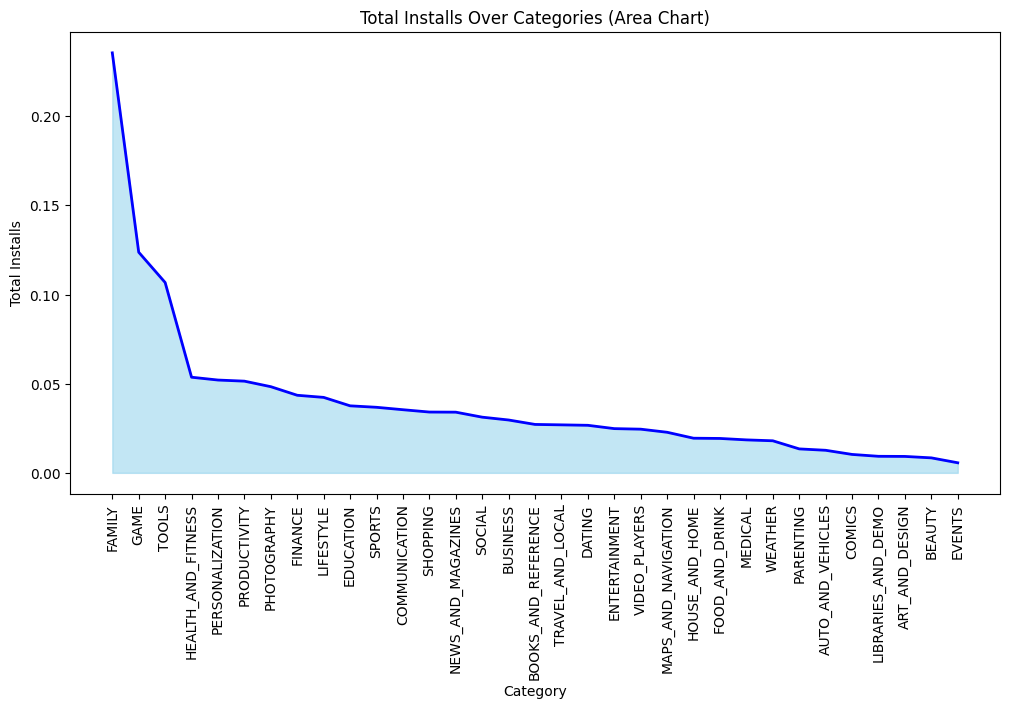

In [23]:
category_installs = df1.groupby('Category')['Installs'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12, 6))
plt.fill_between(category_installs['Category'], category_installs['Installs'], color='skyblue', alpha=0.5)
plt.plot(category_installs['Category'], category_installs['Installs'], color='blue', linewidth=2)
plt.xticks(rotation=90)
plt.title('Total Installs Over Categories (Area Chart)')
plt.xlabel('Category')
plt.ylabel('Total Installs')
plt.show()


12.Scatter Plot with Size Mapping (Reviews vs Installs)

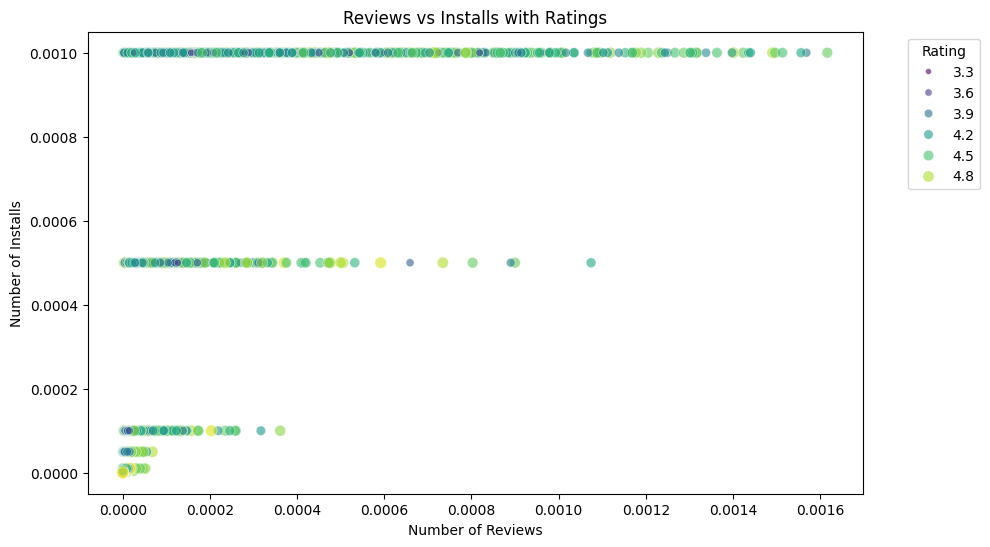

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df1, x='Reviews', y='Installs', size='Rating', hue='Rating', palette='viridis', alpha=0.6)
plt.title('Reviews vs Installs with Ratings')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Installs')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


13.Histogram of Ratings

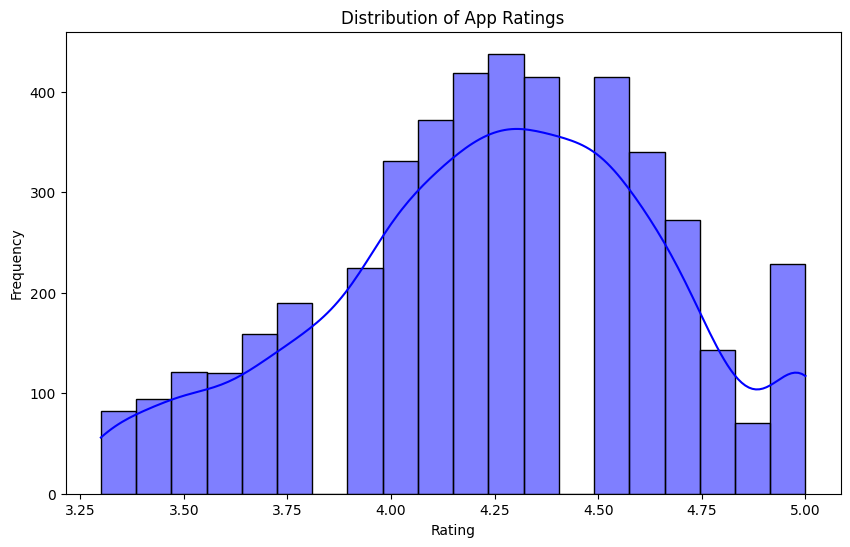

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(df1['Rating'], bins=20, kde=True, color='blue')
plt.title('Distribution of App Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


14.Distribution Plot of Sentiment Polarity

C:\Users\DELL\AppData\Local\Temp\ipykernel_12132\1888520625.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=merged_df, x='Sentiment_Polarity', hue='Sentiment', fill=True, common_norm=False, palette='coolwarm')


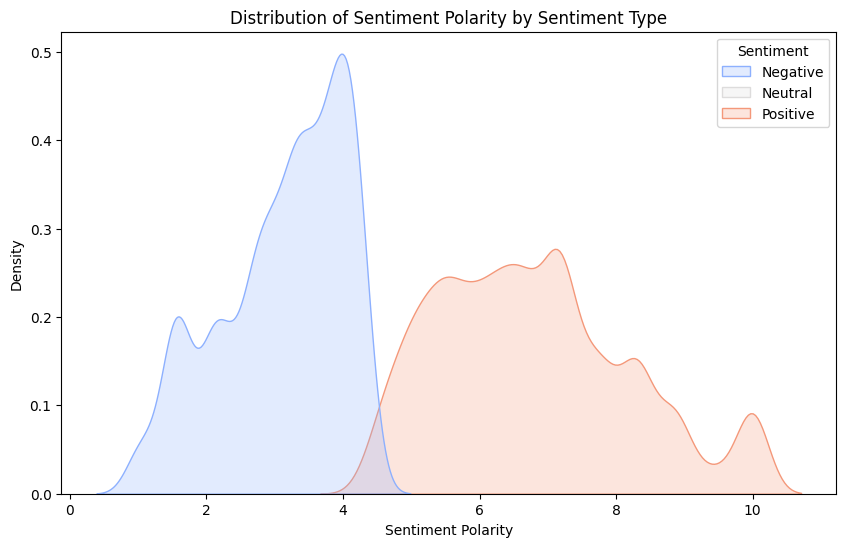

In [26]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=merged_df, x='Sentiment_Polarity', hue='Sentiment', fill=True, common_norm=False, palette='coolwarm')
plt.title('Distribution of Sentiment Polarity by Sentiment Type')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Density')
plt.show()


15.Rating and Sentiment Polarity values
What does the distribution of differences tell us about the relationship between these columns?

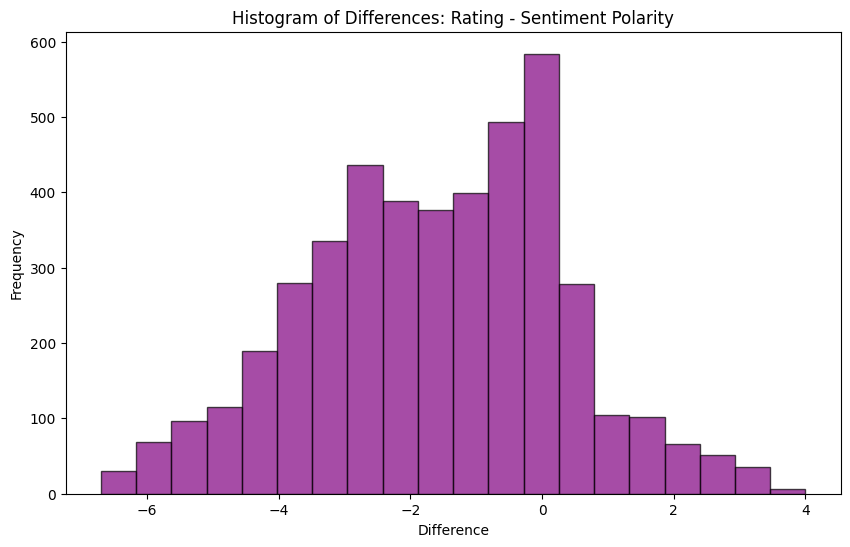

In [29]:
# Compute the difference
difference = df1['Rating'] - merged_df['Sentiment_Polarity']

# Plot the histogram of the differences
plt.figure(figsize=(10, 6))
plt.hist(difference.dropna(), bins=20, color='purple', edgecolor='black', alpha=0.7)
plt.title('Histogram of Differences: Rating - Sentiment Polarity')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()


16.Proportion of Apps

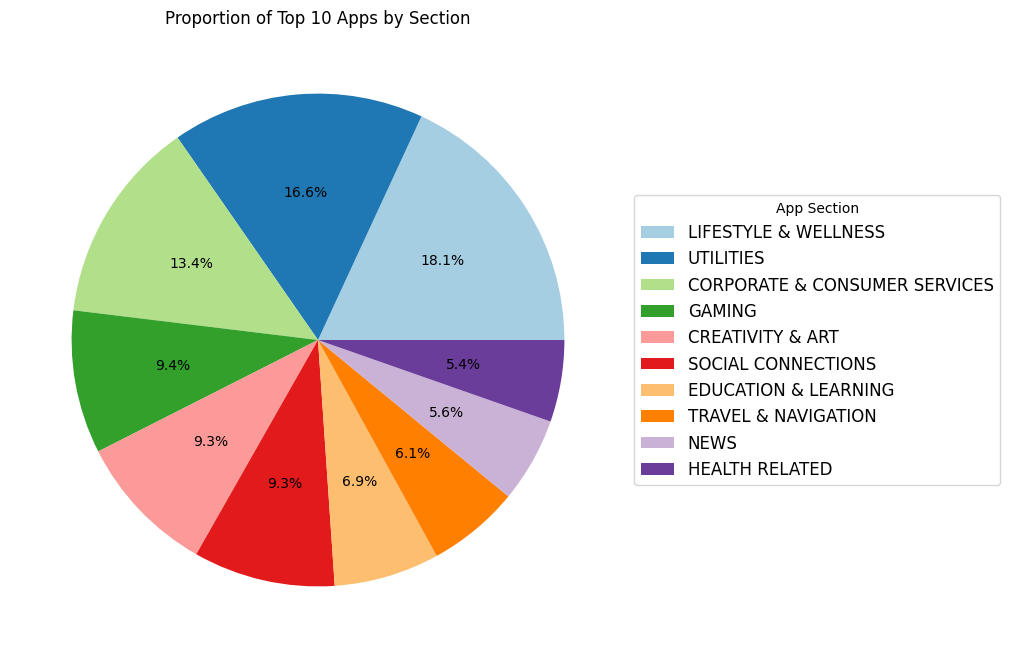

In [40]:
# Get the top 10 most frequent Sections
section_counts_top_10 = df1['Section'].value_counts().head(10)

# Create the pie chart without text around the pie
plt.figure(figsize=(8, 8))
plt.pie(section_counts_top_10, autopct='%1.1f%%', colors=plt.cm.Paired.colors)

# Add the title
plt.title('Proportion of Top 10 Apps by Section')

# Add legend outside the pie chart and increase size
plt.legend(section_counts_top_10.index, title='App Section', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

# Show the plot
plt.show()
